In [119]:
!pip install scikit-fuzzy
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install scipy
!pip install matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
import skfuzzy as fuzz

# Lectura de datos
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_data = pd.read_csv('./iris2Clases.txt', header=None, names=column_names)
iris_data = iris_data[(iris_data['class'] == 'Iris-setosa') | (iris_data['class'] == 'Iris-versicolor')]
X = iris_data.drop('class', axis=1).values
y = iris_data['class'].replace({'Iris-setosa': 0, 'Iris-versicolor': 1}).values
data = np.column_stack((X, y))

import pandas as pd

# Definir los valores deseados para y
etiquetas = [{'sepal_length': 5.1, 'sepal_width': 3.5, 'petal_length': 1.4, 'petal_width': 0.2, 'class': 'Iris-setosa'},
             {'sepal_length': 6.9, 'sepal_width': 3.1, 'petal_length': 4.9, 'petal_width': 1.5, 'class': 'Iris-versicolor'},
             {'sepal_length': 5.0, 'sepal_width': 3.4, 'petal_length': 1.5, 'petal_width': 0.2, 'class': 'Iris-setosa'}]

# Convertir a un DataFrame de Pandas
y_data = pd.DataFrame(etiquetas)



def inicializar_centroides(data, k):
    centroides = data[np.random.choice(data.shape[0], k, replace=False), :]
    return centroides

def asignar_grupos(data, centroides):
    distancias = np.array([np.linalg.norm(data - centro, axis=1) for centro in centroides])
    grupos = np.argmin(distancias, axis=0)
    return grupos

def actualizar_centroides(data, grupos, k):
    centroides = np.array([data[grupos == i].mean(axis=0) for i in range(k)])
    return centroides

def kmeans_manual(data, k, max_iter=300, tol=1e-2, n_init=10):
    mejor_inercia = np.inf
    mejor_grupos = None
    mejor_centroides = None

    for _ in range(n_init):
        centroides = inicializar_centroides(data, k)
        cambios = np.inf

        for _ in range(max_iter):
            grupos = asignar_grupos(data, centroides)
            nuevos_centroides = actualizar_centroides(data, grupos, k)
            cambios = np.linalg.norm(nuevos_centroides - centroides)

            if cambios < tol:
                break

            centroides = nuevos_centroides

        inercia = np.sum([np.sum(np.linalg.norm(data[grupos == i] - centroides[i], axis=1)**2) for i in range(k)])

        if inercia < mejor_inercia:
            mejor_inercia = inercia
            mejor_grupos = grupos
            mejor_centroides = centroides

    return mejor_grupos, mejor_centroides

def inicializar_matriz_u(data, k):
    n = data.shape[0]
    matriz_u = np.random.rand(n, k)
    matriz_u = matriz_u / matriz_u.sum(axis=1)[:, np.newaxis]
    return matriz_u

def calcular_centroides(data, matriz_u, peso_exponencial):
    u_exp = matriz_u ** peso_exponencial
    centroides = (u_exp.T @ data) / u_exp.sum(axis=0)[:, np.newaxis]
    return centroides

def actualizar_matriz_u(data, centroides, peso_exponencial, k):
    distancias = np.array([[np.linalg.norm(punto - centro) for centro in centroides] for punto in data])
    distancias = distancias ** (2 / (peso_exponencial - 1))
    matriz_u = 1 / np.sum((1 / distancias)[:, :k, np.newaxis], axis=1)
    return matriz_u

def fuzzy_cmeans_manual(data, k, peso_exponencial, tol=1e-4, max_iter=300):
    n = data.shape[0]
    matriz_pertenencia = inicializar_matriz_u(data, k)
    cambios = np.inf

    for _ in range(max_iter):
        centroides = calcular_centroides(data, matriz_pertenencia, peso_exponencial)
        nueva_matriz_pertenencia = actualizar_matriz_u(data, centroides, peso_exponencial, k)
        cambios = np.linalg.norm(nueva_matriz_pertenencia - matriz_pertenencia)

        if cambios < tol:
            break

        matriz_pertenencia = nueva_matriz_pertenencia

    grupos = np.argmax(matriz_pertenencia, axis=1)

    return grupos, centroides

def bayes(X, classes, x_test):
    class_likelihood = []
    for c in classes:
        X_c = X[X[:, -1] == c][:, :-1]
        class_mean = np.mean(X_c, axis=0)
        class_cov = np.cov(X_c.T)
        class_prior = len(X_c) / len(X)
        class_likelihood.append(multivariate_normal.pdf(x_test, mean=class_mean, cov=class_cov) * class_prior)
    return classes[np.argmax(class_likelihood)]
    
def lloyd(X, k, eta=0.1, epsilon=1e-10, kmax=10):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X[:, :-1])
    n_samples = X_scaled.shape[0]
    c = np.random.rand(k, X_scaled.shape[1])
    iteration = 0
    while iteration < kmax:
        clusters = [[] for _ in range(k)]
        for i, sample in enumerate(X_scaled):
            distances = np.sqrt(np.sum((c - sample)**2, axis=1))
            clusters[np.argmin(distances)].append(i)

        new_c = np.zeros_like(c)
        for i in range(k):
            cluster_mean = np.mean(X_scaled[clusters[i]], axis=0)
            new_c[i] = c[i] + eta * (cluster_mean - c[i])

        if np.max(np.abs(c - new_c)) < epsilon:
            break

        c = new_c
        iteration += 1

    labels = np.zeros(n_samples)
    for i, sample in enumerate(X_scaled):
        distances = np.sqrt(np.sum((c - sample)**2, axis=1))
        labels[i] = np.argmin(distances)
        
    return labels,c



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\Morwar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


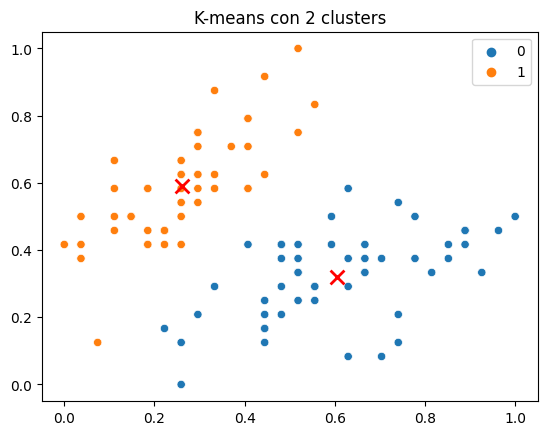

In [120]:
# Definir el número de clusters
k = 2

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar el algoritmo K-means
grupos, centroides = kmeans_manual(X_scaled, k)

# Visualizar los resultados
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=grupos)
sns.scatterplot(x=centroides[:, 0], y=centroides[:, 1], color='red', marker='x', s=100, linewidth=2)
plt.title(f'K-means con {k} clusters')
plt.show()


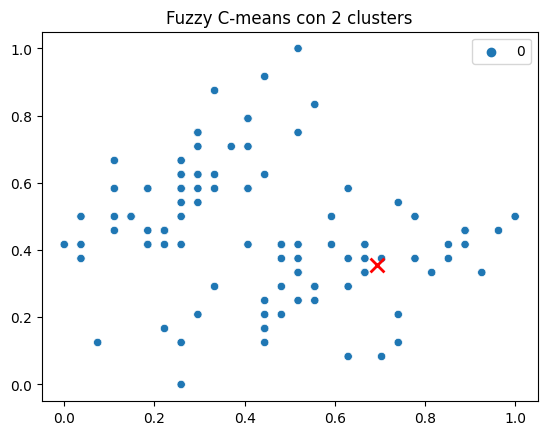

In [121]:
# Definir el número de clusters y el peso exponencial
k = 2
peso_exponencial = 2

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar el algoritmo Fuzzy C-means
grupos, centroides = fuzzy_cmeans_manual(X_scaled, k, peso_exponencial)

# Visualizar los resultados
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=grupos)
sns.scatterplot(x=centroides[:, 0], y=centroides[:, 1], color='red', marker='x', s=100, linewidth=2)
plt.title(f'Fuzzy C-means con {k} clusters')
plt.show()


In [123]:
# Obtener los valores únicos de las clases
classes = np.unique(y)

# Entrenar el clasificador Bayesiano
predictions = []
for sample in X:
    prediction = bayes(data, classes, sample)
    predictions.append(prediction)

# Evaluar el resultado
accuracy = np.mean(predictions == y)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


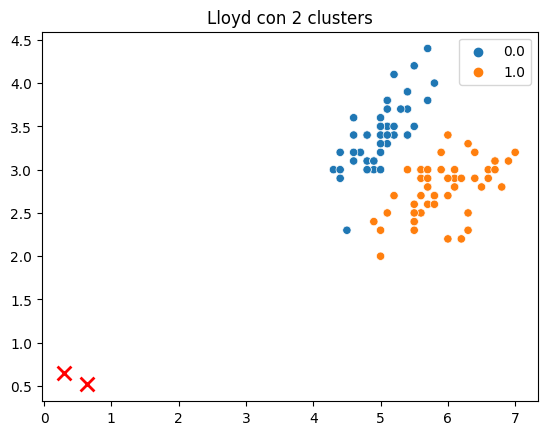

In [124]:
# Definir el número de clusters
k = 2

# Aplicar el algoritmo Lloyd
labels, centroides = lloyd(data, k)

# Visualizar los resultados
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels)
sns.scatterplot(x=centroides[:, 0], y=centroides[:, 1], color='red', marker='x', s=100, linewidth=2)
plt.title(f'Lloyd con {k} clusters')
plt.show()
